<a href="https://colab.research.google.com/github/Nik8x/Titanic_Pyspark_Age_Missing_Prediction/blob/master/Titanic_Pyspark_Age_Missing_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.3.2/spark-2.3.2-bin-hadoop2.7.tgz
!tar xf spark-2.3.2-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.2-bin-hadoop2.7"

In [38]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

sc = spark.sparkContext

import pandas as pd
import matplotlib.pyplot as plt

from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.sql.functions import col

# for google colab
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir("/content/drive/My Drive/Colab Notebooks/files")
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
dfff.csv       test_list.txt  Titanic.json  val_list.txt
SwannsWay.txt  titanic.csv    Titanic.py


In [0]:
# I have downloaded Titanic.json file which I was working on zeppelin, I'll convert it to .py and copy paste lines from there to here

import sys
input_file_name = sys.argv[1]
output_file_name = sys.argv[2]

import json
import codecs
notebook = json.load(codecs.open('Titanic.json', 'r', 'utf-8-sig'))

script = []
for i in notebook["paragraphs"]:
    para = i["text"].splitlines()[1:]
    if len(para) > 0:
        para = '\n'.join(para)
        script.append(para)
script_f = '\n\n'.join(script)

with open('Titanic.py', 'w') as the_file:
    the_file.write(script_f)

In [0]:
#df = spark.read.option("header", "true").csv("/content/drive/My Drive/Colab Notebooks/files/titanic.csv")
df = (spark.read.format("csv").options(header="true").load("/content/drive/My Drive/Colab Notebooks/files/titanic.csv"))

In [6]:
df.printSchema()

root
 |-- row.names: string (nullable = true)
 |-- pclass: string (nullable = true)
 |-- survived: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- home.dest: string (nullable = true)
 |-- room: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- boat: string (nullable = true)
 |-- sex: string (nullable = true)



In [7]:
df.show(4)

+---------+------+--------+--------------------+----+-----------+--------------------+----+----------+-----+------+
|row.names|pclass|survived|                name| age|   embarked|           home.dest|room|    ticket| boat|   sex|
+---------+------+--------+--------------------+----+-----------+--------------------+----+----------+-----+------+
|        1|   1st|       1|Allen, Miss Elisa...|29.0|Southampton|        St Louis, MO| B-5|24160 L221|    2|female|
|        2|   1st|       0|Allison, Miss Hel...| 2.0|Southampton|Montreal, PQ / Ch...| C26|      null| null|female|
|        3|   1st|       0|Allison, Mr Hudso...|30.0|Southampton|Montreal, PQ / Ch...| C26|      null|(135)|  male|
|        4|   1st|       0|Allison, Mrs Huds...|25.0|Southampton|Montreal, PQ / Ch...| C26|      null| null|female|
+---------+------+--------+--------------------+----+-----------+--------------------+----+----------+-----+------+
only showing top 4 rows



In [8]:
df.count()

1313

In [9]:
df.select("age", "survived").show(4)

+----+--------+
| age|survived|
+----+--------+
|29.0|       1|
| 2.0|       0|
|30.0|       0|
|25.0|       0|
+----+--------+
only showing top 4 rows



In [10]:
df.groupby("survived").count().show()

+--------+-----+
|survived|count|
+--------+-----+
|       0|  864|
|       1|  449|
+--------+-----+



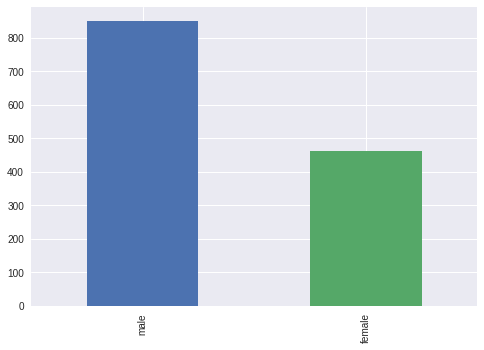

In [46]:
#Bar chart of no. of people survived
df.toPandas().sex.value_counts().plot.bar()
plt.show()

In [11]:
df.groupby("age", "survived").count().show()

+------+--------+-----+
|   age|survived|count|
+------+--------+-----+
|  53.0|       1|    3|
|  39.0|       1|    5|
|   7.0|       1|    1|
|  45.0|       1|    9|
|  21.0|       0|   14|
|   5.0|       0|    1|
|  65.0|       0|    2|
|0.3333|       0|    1|
|0.9167|       1|    1|
|  67.0|       0|    1|
|  46.0|       1|    1|
|  36.0|       0|    7|
|  29.0|       0|    6|
|  44.0|       0|    4|
|  24.0|       0|   12|
|  25.0|       1|    5|
|  61.0|       0|    3|
|  37.0|       1|    2|
|  18.0|       0|   15|
|  35.0|       1|    6|
+------+--------+-----+
only showing top 20 rows



In [47]:
# check missing values in all columns using pandas dataframe
df.toPandas().isnull().sum()

rows            0
pclass          0
survived        0
name            0
age           680
home.dest     559
room         1236
ticket       1244
boat          966
sex             0
dtype: int64

In [12]:
# check missing values in all columns
print(df.where(col("age").isNull()).count())
print(df.where(col("pclass").isNull()).count())
print(df.where(col("survived").isNull()).count())
print(df.where(col("embarked").isNull()).count())
print(df.where(col("sex").isNull()).count())

680
0
0
492
0


In [13]:
df.describe('age').show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               633|
|   mean| 31.19418104265403|
| stddev|14.747525275652208|
|    min|            0.1667|
|    max|               9.0|
+-------+------------------+



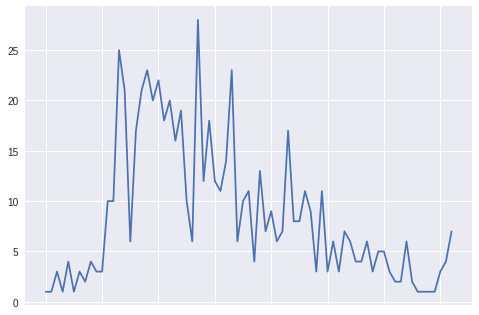

In [43]:
# line plot of Age
df.toPandas().age.value_counts().sort_index().plot.line()
plt.show()

In [14]:
print(df.count(), len(df.columns))

1313 11


In [15]:
df = df.withColumn("AGEImputed", (df["age"] * 0))

df.show(15)

+---------+------+--------+--------------------+------+-----------+--------------------+-----+-----------------+-----+------+----------+
|row.names|pclass|survived|                name|   age|   embarked|           home.dest| room|           ticket| boat|   sex|AGEImputed|
+---------+------+--------+--------------------+------+-----------+--------------------+-----+-----------------+-----+------+----------+
|        1|   1st|       1|Allen, Miss Elisa...|  29.0|Southampton|        St Louis, MO|  B-5|       24160 L221|    2|female|       0.0|
|        2|   1st|       0|Allison, Miss Hel...|   2.0|Southampton|Montreal, PQ / Ch...|  C26|             null| null|female|       0.0|
|        3|   1st|       0|Allison, Mr Hudso...|  30.0|Southampton|Montreal, PQ / Ch...|  C26|             null|(135)|  male|       0.0|
|        4|   1st|       0|Allison, Mrs Huds...|  25.0|Southampton|Montreal, PQ / Ch...|  C26|             null| null|female|       0.0|
|        5|   1st|       1|Allison, Maste

In [16]:
df = df.withColumnRenamed("row.names", "rows")

imputed = df.select("rows", "AGEImputed").fillna(1)  # making a new dataframe with filling missing values in AGEImputed, also including rows column so we can merge this to original df

imputed_e = df.select("rows", "embarked").fillna('Southampton')

df = df.drop("AGEImputed", "embarked")  # so we have a new imputed dataframe with 1 and 0 for age missing, let's drop the AGEImputed column from df
df.show(4)

+----+------+--------+--------------------+----+--------------------+----+----------+-----+------+
|rows|pclass|survived|                name| age|           home.dest|room|    ticket| boat|   sex|
+----+------+--------+--------------------+----+--------------------+----+----------+-----+------+
|   1|   1st|       1|Allen, Miss Elisa...|29.0|        St Louis, MO| B-5|24160 L221|    2|female|
|   2|   1st|       0|Allison, Miss Hel...| 2.0|Montreal, PQ / Ch...| C26|      null| null|female|
|   3|   1st|       0|Allison, Mr Hudso...|30.0|Montreal, PQ / Ch...| C26|      null|(135)|  male|
|   4|   1st|       0|Allison, Mrs Huds...|25.0|Montreal, PQ / Ch...| C26|      null| null|female|
+----+------+--------+--------------------+----+--------------------+----+----------+-----+------+
only showing top 4 rows



In [17]:
df.columns, imputed.columns, imputed_e.columns

(['rows',
  'pclass',
  'survived',
  'name',
  'age',
  'home.dest',
  'room',
  'ticket',
  'boat',
  'sex'],
 ['rows', 'AGEImputed'],
 ['rows', 'embarked'])

In [18]:
titanic = df.join(imputed, ['rows'])  # merging df and imputed on rows column and saving in titanic
titanic = titanic.join(imputed_e, ['rows'])
titanic.show(15)

+----+------+--------+--------------------+------+--------------------+-----+-----------------+-----+------+----------+-----------+
|rows|pclass|survived|                name|   age|           home.dest| room|           ticket| boat|   sex|AGEImputed|   embarked|
+----+------+--------+--------------------+------+--------------------+-----+-----------------+-----+------+----------+-----------+
|   1|   1st|       1|Allen, Miss Elisa...|  29.0|        St Louis, MO|  B-5|       24160 L221|    2|female|       0.0|Southampton|
|   2|   1st|       0|Allison, Miss Hel...|   2.0|Montreal, PQ / Ch...|  C26|             null| null|female|       0.0|Southampton|
|   3|   1st|       0|Allison, Mr Hudso...|  30.0|Montreal, PQ / Ch...|  C26|             null|(135)|  male|       0.0|Southampton|
|   4|   1st|       0|Allison, Mrs Huds...|  25.0|Montreal, PQ / Ch...|  C26|             null| null|female|       0.0|Southampton|
|   5|   1st|       1|Allison, Master H...|0.9167|Montreal, PQ / Ch...|  C22

In [19]:
# check missing values in all columns
print(titanic.where(col("age").isNull()).count())
print(titanic.where(col("pclass").isNull()).count())
print(titanic.where(col("survived").isNull()).count())
print(titanic.where(col("embarked").isNull()).count())
print(titanic.where(col("sex").isNull()).count())

680
0
0
0
0


In [20]:
# now we can select the rows, name, ticket, boat, room, home.dest columns from titanic, and change age dataype from string to float
titanic = titanic.select('pclass', 'survived', 'embarked', 'sex', 'AGEImputed', titanic.age.cast('float'))

test = titanic.filter(col("AGEImputed") == 1)  # dataframe for which we have missing age
train = titanic.filter(col("AGEImputed") == 0)  # dataframe for which we have age values

(train, validation) = train.randomSplit([.7, .3])

# now we can drop the AGEImputed column from both these dataframes
# test = test.drop("AGEImputed")
# train = train.drop("AGEImputed")

print('test columns: ', test.columns)
print('train columns: ', train.columns)
print('validation columns: ', validation.columns)

print("Number of training records: " + str(train.count()))
print("Number of testing records : " + str(test.count()))
print("Number of validation records : " + str(validation.count()))

test columns:  ['pclass', 'survived', 'embarked', 'sex', 'AGEImputed', 'age']
train columns:  ['pclass', 'survived', 'embarked', 'sex', 'AGEImputed', 'age']
validation columns:  ['pclass', 'survived', 'embarked', 'sex', 'AGEImputed', 'age']
Number of training records: 451
Number of testing records : 680
Number of validation records : 182


In [22]:
x = StringIndexer(inputCol = "pclass", outputCol = "pclass_1").fit(train).transform(train)
OneHotEncoder(inputCol = "pclass_1", outputCol = "pclass_2").transform(x).show(10)   # demonstrating the work of OneHotEncoder with StringIndexer

+------+--------+---------+------+----------+----+--------+-------------+
|pclass|survived| embarked|   sex|AGEImputed| age|pclass_1|     pclass_2|
+------+--------+---------+------+----------+----+--------+-------------+
|   1st|       0|Cherbourg|female|       0.0|36.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|female|       0.0|50.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|18.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|24.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|25.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|27.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|28.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|32.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|33.0|     0.0|(2,[0],[1.0])|
|   1st|       0|Cherbourg|  male|       0.0|36.0|     0.0|(2,[0],[1.0])|
+------+--------+---------+------+----

In [0]:
si_pclass = StringIndexer(inputCol = "pclass", outputCol = "pclass_1")
si_embarked = StringIndexer(inputCol = "embarked", outputCol = "embarked_1")
si_survived = StringIndexer(inputCol = "survived", outputCol = "survived_1")
si_sex = StringIndexer(inputCol = "sex", outputCol = "sex_1")

vectorAssembler_features = VectorAssembler(inputCols = ["pclass_1", "embarked_1", "sex_1", "survived_1"], outputCol = "features")

rf = RandomForestRegressor(labelCol = "age", featuresCol = "features")  # random forest regressor

lr = LinearRegression(maxIter = 10, regParam = .01, labelCol = "age", featuresCol = "features")  # linear regression

pipeline_rf = Pipeline(stages = [si_pclass, si_embarked, si_survived, si_sex, vectorAssembler_features, rf])  # # pipeline for random forest

pipeline_lr = Pipeline(stages = [si_pclass, si_embarked, si_survived, si_sex, vectorAssembler_features, lr])  # pipeline for linear regression

In [24]:
train.printSchema()

root
 |-- pclass: string (nullable = true)
 |-- survived: string (nullable = true)
 |-- embarked: string (nullable = false)
 |-- sex: string (nullable = true)
 |-- AGEImputed: double (nullable = false)
 |-- age: float (nullable = true)



In [0]:
model_rf = pipeline_rf.fit(train)
model_lr = pipeline_lr.fit(train)

In [0]:
prediction_rf = model_rf.transform(validation)
prediction_lr = model_lr.transform(validation)

In [27]:
prediction_rf.show(4)
prediction_lr.show(4)

+------+--------+---------+----+----------+----+--------+----------+----------+-----+-------------+------------------+
|pclass|survived| embarked| sex|AGEImputed| age|pclass_1|embarked_1|survived_1|sex_1|     features|        prediction|
+------+--------+---------+----+----------+----+--------+----------+----------+-----+-------------+------------------+
|   1st|       0|Cherbourg|male|       0.0|27.0|     0.0|       1.0|       0.0|  0.0|(4,[1],[1.0])|44.350357087186076|
|   1st|       0|Cherbourg|male|       0.0|30.0|     0.0|       1.0|       0.0|  0.0|(4,[1],[1.0])|44.350357087186076|
|   1st|       0|Cherbourg|male|       0.0|48.0|     0.0|       1.0|       0.0|  0.0|(4,[1],[1.0])|44.350357087186076|
|   1st|       0|Cherbourg|male|       0.0|58.0|     0.0|       1.0|       0.0|  0.0|(4,[1],[1.0])|44.350357087186076|
+------+--------+---------+----+----------+----+--------+----------+----------+-----+-------------+------------------+
only showing top 4 rows

+------+--------+------

In [0]:
def regeval(pred_x):
  eval = RegressionEvaluator(labelCol = "age", predictionCol = "prediction", metricName = "rmse")

  # Root Mean Square Error
  rmse = eval.evaluate(pred_x)
  print("RMSE: %.3f" % rmse)

  # Mean Square Error
  mse = eval.evaluate(pred_x, {eval.metricName: "mse"})
  print("MSE: %.3f" % mse)

  # Mean Absolute Error
  mae = eval.evaluate(pred_x, {eval.metricName: "mae"})
  print("MAE: %.3f" % mae)

  # r2 - coefficient of determination
  r2 = eval.evaluate(pred_x, {eval.metricName: "r2"})
  print("r2: %.3f" %r2)

In [31]:
regeval(prediction_lr) # Linear Regression

RMSE: 13.444
MSE: 180.752
MAE: 11.038
r2: 0.180


In [32]:
regeval(prediction_rf) # Random Forest

RMSE: 13.307
MSE: 177.083
MAE: 10.657
r2: 0.197
